In [1]:
import os
import pandas as pd
from types import SimpleNamespace
import matplotlib.pyplot as plt

# see https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
# for why we use multiprocess rather than multiprocessing,
from multiprocess import Pool

import src.utils as utils
import src.initial as initial
import src.target as target
from src.proposals import norm
import src.mcmc as mcmc

utils.configure_pd(pd)
utils.configure_plt(plt)

In [2]:
%%time

d, ell2 = 100, 2.38**2

mode_pairs_grid = [('full_max_indep','na'),
                   ('full_max_refl','na'),
                   ('max_indep','same_u'),
                   ('max_indep','cond_same_u'),
                   ('max_refl','same_u'),
                   ('max_refl','cond_same_u')]

# for paper, n_rep = 1000
pl = utils.add_iter([{'n_rep':1000, 'n_iter':2500,
                      'prop_mode':prop_mode, 'ar_mode':ar_mode,
                      'd':d, 'ell2':ell2}
                     for (prop_mode, ar_mode) in mode_pairs_grid])

def f(par):
    n = SimpleNamespace(**par)
    pr = f' - d = {n.d}, prop_mode = {n.prop_mode}, ar_mode = {n.ar_mode} ({n.i}/{n.i_total})'

    init = initial.Initialize(d=n.d, mode='target_indep')
    prop = norm.NormalProposal(d=n.d, sigma2=n.ell2/n.d, prop_mode=n.prop_mode)
    targ = target.NormalTarget(d=n.d, sigma2=1)

    cmh = mcmc.CoupledMH(init, prop, targ, break_condition='none',
                         ar_mode=n.ar_mode, record_items=('r'))
    # break_condition='none', so we run to n_iter iterations no matter what
    cmh.run(n_iter=n.n_iter, n_rep=n.n_rep, verbose=True, pr_postfix=pr)

    df0 = cmh.return_df()
    df0['mode'] = f'{n.prop_mode} {n.ar_mode}'
    return df0

df_list = []
with Pool(os.cpu_count()-2) as p:
    df_list += p.map(f, pl)

df = pd.concat(df_list)

100 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
100 - d = 100, prop_mode = max_indep, ar_mode = same_u (2/6)
200 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
300 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
100 - d = 100, prop_mode = full_max_indep, ar_mode = na (0/6)
200 - d = 100, prop_mode = max_indep, ar_mode = same_u (2/6)
400 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
500 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
300 - d = 100, prop_mode = max_indep, ar_mode = same_u (2/6)
600 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
200 - d = 100, prop_mode = full_max_indep, ar_mode = na (0/6)
700 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
400 - d = 100, prop_mode = max_indep, ar_mode = same_u (2/6)
800 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
900 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
500 - d = 100, prop_mode = max_indep, ar_mode = same_u (2/6)
1000 - d = 100, prop_mode = max

Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:


KeyboardInterrupt: 

In [20]:
# process output
df_avg = df.groupby(['mode','t']).mean().reset_index()
df_p = df_avg.pivot(index='t',columns='mode',values='r_curr')
mode_summary = df_p.columns.tolist()
df_p.reset_index(inplace=True)

#df_p.to_hdf('df_p_fig8.h5','df_p')

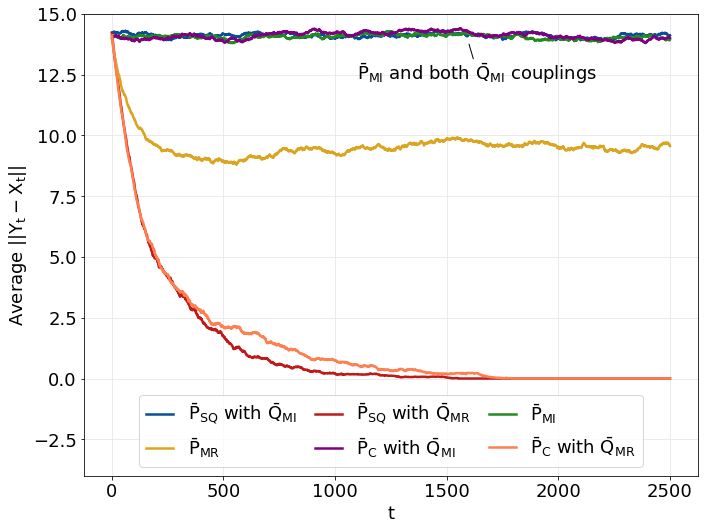

In [19]:
# Produce Figure 8: avg distance between chains by iteration and coupling

# Note that we want the order and labeling to be the same for all figures
mode_pairs = [
    ('max_indep same_u', r'$\bar{P}_{SQ}$ with $\bar{Q}_{MI}$'),
    ('max_refl same_u', r'$\bar{P}_{SQ}$ with $\bar{Q}_{MR}$'),
    ('full_max_indep na', r'$\bar{P}_{MI}$'),
    ('full_max_refl na', r'$\bar{P}_{MR}$'),
    ('max_indep cond_same_u', r'$\bar{P}_C$ with $\bar{Q}_{MI}$'),
    ('max_refl cond_same_u', r'$\bar{P}_C$ with $\bar{Q}_{MR}$')
]

mode_disp = [m[0] for m in mode_pairs]
mode_labs = [m[1] for m in mode_pairs]

ax = df_p.plot(x='t', y=mode_disp)

plt.annotate(r'$\bar{P}_{MI}$ and both $\bar{Q}_{MI}$ couplings',
             xy=(1600, 13.75), xytext=(1100, 12.3),
             arrowprops={'arrowstyle':'-','shrinkA':0, 'shrinkB':0})

handles, labels = ax.get_legend_handles_labels()
ord = [0,3,1,4,2,5]
handles2 = [handles[i] for i in ord]
labels2 = [mode_labs[i] for i in ord]
plt.legend(labels=labels2, handles=handles2, loc='lower center',
           ncol=3, handlelength=1.5, columnspacing=1)

plt.xlabel('t')
plt.ylabel(r'Average $||Y_t-X_t||$')

plt.ylim(ymin=-4, ymax=15)

plt.show()